# Credit Momentum

1. Societe Generale: Trend-following and mean-reversion strategies on credit indices
2. Societe Generale: Momentum strategies in credit: A review of different trend strategies applied to credit indices
3. Societe Generale: Credit Momentum Strategy

# Packages

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import tsmoothie as ts

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from CreditDataPrep import CreditDataPrep

# Get Data

In [2]:
def _get_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(rtn = lambda x: x.value.pct_change()).
        dropna())

def get_data() -> pd.DataFrame: 
    
    df_raw = CreditDataPrep().get_data()

    df_log_spread = (df_raw.query(
        "group_short == 'Spread'").
        assign(log_spread = lambda x: np.log(x.value)))

    df_index = (df_raw.query(
        "asset_class == 'CDS' & group_short == 'Index'").
        drop(columns = ["group_short", "asset_class"]).
        assign(group_name = lambda x: x.security.str.split(" ").str[1]).
        groupby("security").
        apply(_get_rtn).
        reset_index(drop = True))
    
    return df_log_spread, df_index

df_log_spread, df_index = get_data()

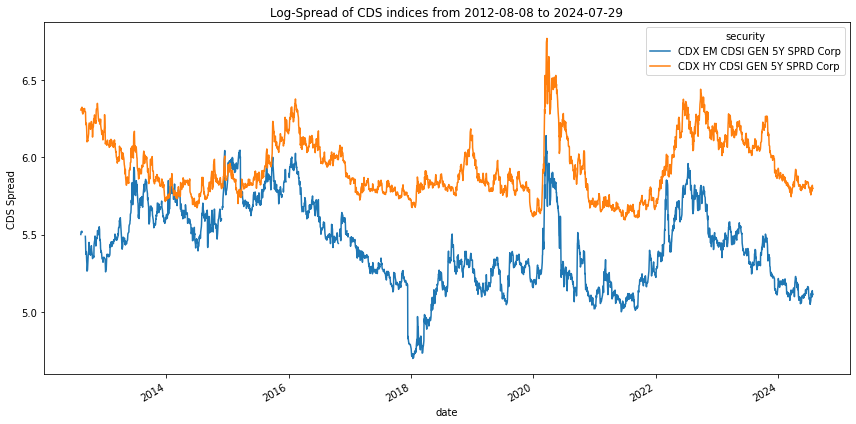

In [3]:
def plot_log_spread(df_log_spread: pd.DataFrame) -> plt.Figure: 
    
    (df_log_spread[
        ["date", "security", "log_spread"]].
        pivot(index = "date", columns = "security", values = "log_spread").
        plot(
            ylabel = "CDS Spread",
            figsize = (12,6),
            title = "Log-Spread of CDS indices from {} to {}".format(
                df_log_spread.date.min().date(),
                df_log_spread.date.max().date())))
    
    plt.tight_layout()
    
plot_log_spread(df_log_spread)

In [4]:
def _kalman_filter(df: pd.DataFrame) -> pd.DataFrame: 

    kalman_smoother = (ts.smoother.KalmanSmoother(
        component = "level", 
        component_noise={'level':0.2, 'trend':0.2, 'season':0.2}))
    
    df_out = (df.sort_values(
        "date").
        assign(
            smooth = lambda x: kalman_smoother.smooth(x.log_spread).smooth_data.T,
            mean_reversion = lambda x: x.log_spread - x.smooth))
    
    return df_out

def kalman_filter(df_log_spread: pd.DataFrame) -> pd.DataFrame: 

    df_kalman = (df_log_spread[
        ["date", "security", "log_spread"]].
        assign(security = lambda x: x.security.str.split(" ").str[1]).
        groupby("security").
        apply(_kalman_filter).
        reset_index(drop = True).
        melt(id_vars = ["date", "security", "log_spread"]))
    
    return df_kalman

df_kalman = kalman_filter(df_log_spread)

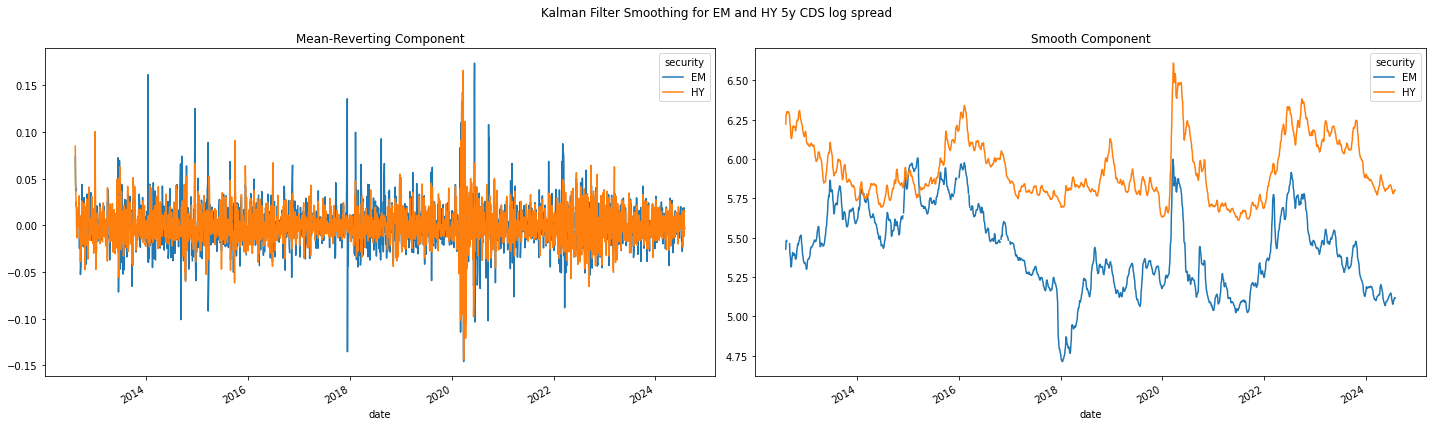

In [5]:
def plot_kalman_components(df_kalman: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_kalman.drop(
        columns = ["log_spread"]).
        pivot(index = ["date", "variable"], columns = "security", values = "value").
        reset_index())

    variables = df_tmp.variable.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    renamer = {
        "mean_reversion": "Mean-Reverting Component",
        "smooth": "Smooth Component"}

    for variable, ax in zip(variables, axes.flatten()):

        (df_tmp.query(
            "variable == @variable").
            drop(columns = ["variable"]).
            set_index("date").
            plot(
                title = renamer[variable],
                ax = ax))

    fig.suptitle("Kalman Filter Smoothing for EM and HY 5y CDS log spread")
    plt.tight_layout()
    
plot_kalman_components(df_kalman)

They define the following Trend-Following Strategy <br>
1. 1m rolling $\beta$ of Smooth Component
2. 3m rolling $\beta$ of Smooth Component
3. 1m rolling $\beta$ of Mean-Reverting Component
4. 3m rolling $\beta$ of Mean-Reverting Component


Start by building the signal

In [6]:
def _regression(df: pd.DataFrame, lookback_window: int) -> pd.DataFrame: 
    
    df_tmp = (df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift(lookback_window)).
        dropna())
    
    regression = (RollingOLS(
        endog = df_tmp.value,
        exog = sm.add_constant(df_tmp.lag_value),
        window = lookback_window).
        fit())
    
    df_out = (regression.params.rename(
        columns = {
            "const": "alpha",
            "lag_value": "beta"}).
        assign(
            lookback = lookback_window,
            date = lambda x: df_tmp.date,
            lag_beta = lambda x: x.beta.shift()).
        dropna().
        merge(right = df_tmp, how = "inner", on = ["date"]))
    
    return df_out

def _get_rolling_regression(df: pd.DataFrame, lookback_windows: list) -> pd.DataFrame: 
    
    df_out = (pd.concat(
        [_regression(df, lookback_window) 
         for lookback_window in lookback_windows]))
    
    return df_out

def get_rolling_regression(df: pd.DataFrame, lookback_windows: list = [20, 60]) -> pd.DataFrame: 

    df_regression = (df_kalman.assign(
        group_var = lambda x: x.security + " " + x.variable).
        groupby("group_var").
        apply(_get_rolling_regression, lookback_windows).
        reset_index(drop = True).
        drop(columns = ["group_var"]))
    
    return df_regression

df_regression = get_rolling_regression(df_kalman)

Then they use the sign of the beta as an indicator for buying protection. Start by building the signal first. 

In [7]:
def apply_signal(df_regression: pd.DataFrame, df_index: pd.DataFrame) -> pd.DataFrame: 
    
    df_regress_tmp = (df_regression.assign(
        signal = lambda x: np.sign(x.lag_beta))
        [["date", "signal", "security", "variable", "lookback"]])

    df_index_prep = (df_index[
        ["date", "group_name", "security", "rtn"]].
        assign(renamer = lambda x: x.security.str.split("PRC").str[0]).
        drop(columns = ["security"]).
        rename(columns = {"group_name": "security"}))

    df_prep = (df_index_prep.merge(
        right = df_regress_tmp, how = "inner", on = ["date", "security"]).
        assign(signal_rtn = lambda x: x.signal * x.rtn))
    
    return df_prep

df_signal = apply_signal(df_regression, df_index)

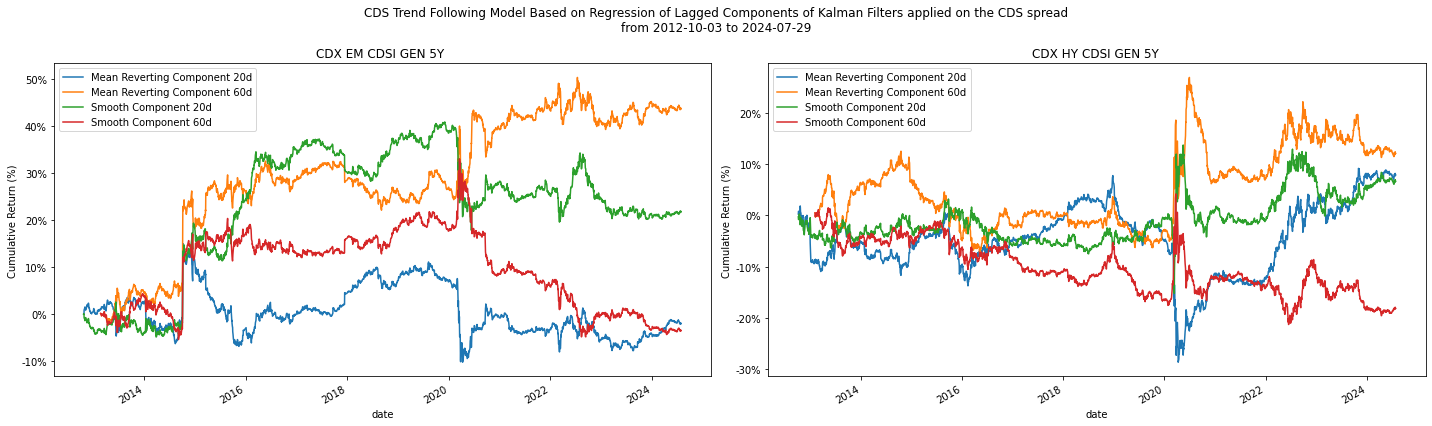

In [8]:
def plot_cumulative_return(df_signal: pd.DataFrame) -> plt.Figure: 

    renamer = {
        "mean_reversion": "Mean Reverting Component",
        "smooth": "Smooth Component"}

    indices = df_signal.renamer.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(indices), figsize = (20,6))

    for index, ax in zip(indices, axes.flatten()): 

        (df_signal.query(
            "renamer == @index").
            replace(renamer).
            assign(strat_name = lambda x: x.variable + " " + x.lookback.astype(str) + "d")
            [["strat_name", "signal_rtn", "date"]].
            pivot(index = "date", columns = "strat_name", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax = ax,
                ylabel = "Cumulative Return (%)",
                title = index))

        ax.legend(title = "")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.suptitle("CDS Trend Following Model Based on Regression of Lagged Components of Kalman Filters applied on the CDS spread\nfrom {} to {}".format(
        df_signal.date.min().date(),
        df_signal.date.max().date()))

    plt.tight_layout()
    
plot_cumulative_return(df_signal)

They use an adaptive method based on picking the maximized rolling 1 month sharpe. First start by getting the 1 month rolling sharpe.

In [9]:
def _get_one_month_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.sort_values(
        "date").
        assign(
            sharpe = lambda x: x.signal_rtn.rolling(window = 20).mean() / x.signal_rtn.rolling(window = 20).std() * np.sqrt(252 / 12),
            lag_sharpe = lambda x: x.sharpe.shift()).
        dropna())
    
    return df_tmp

def get_one_month_sharpe(df_signal: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_signal.assign(
        group_var = lambda x: x.security + " " + x.variable + " " + x.lookback.astype(str)).
        groupby("group_var").
        apply(_get_one_month_sharpe).
        reset_index(drop = True))
    
    return df_out

df_sharpe = get_one_month_sharpe(df_signal)

Plot rolling sharpes

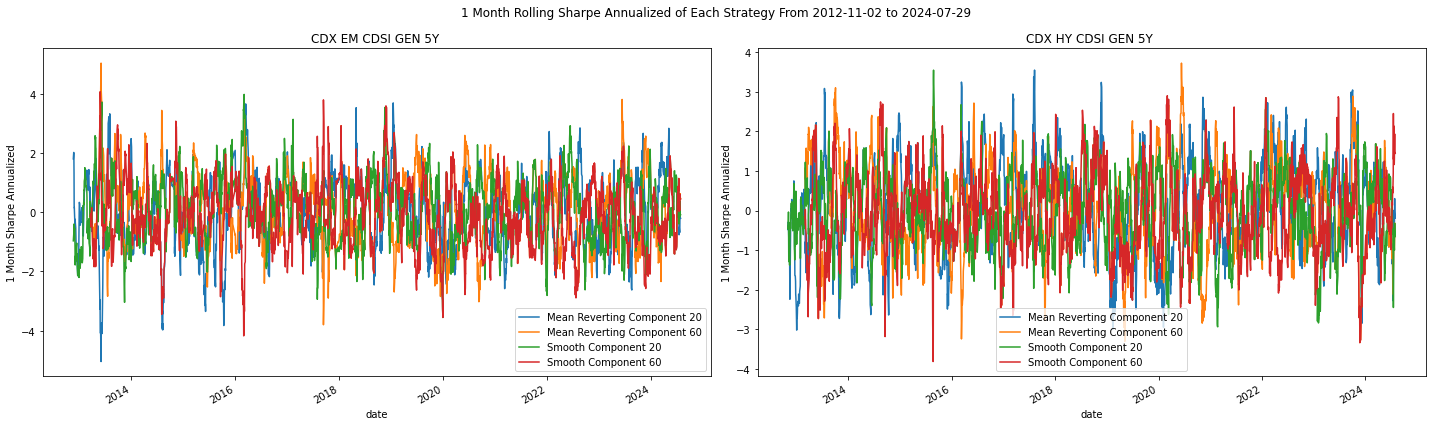

In [10]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "mean_reversion": "Mean Reverting Component",
        "smooth": "Smooth Component"}

    indices = df_signal.renamer.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(indices), figsize = (20,6))

    for index, ax in zip(indices, axes.flatten()): 

        (df_sharpe.query(
            "renamer == @index").
            replace(renamer).
            assign(strat = lambda x: x.variable + " " + x.lookback.astype(str))
            [["strat", "date", "sharpe"]].
            pivot(index = "date", columns = "strat", values = "sharpe").
            plot(
                ax = ax,
                ylabel = "1 Month Sharpe Annualized",
                title = index))

        ax.legend(title = "")

    fig.suptitle("1 Month Rolling Sharpe Annualized of Each Strategy From {} to {}".format(
        df_sharpe.date.min().date(),
        df_sharpe.date.max().date()))

    plt.tight_layout()
    
plot_sharpe(df_sharpe)

Now go through each day and pick the signal that has the max lagged sharpe

In [ ]:
def _get_max(df: pd.DataFrame) -> pd.DataFrame: return(df.query("lag_sharpe == lag_sharpe.max()"))

def _get_max_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out =(df.groupby(
        "date").
        apply(_get_max))
    
    return df_out

def get_max_sharpe(df_sharpe: pd.DataFrame) -> pd.DataFrame: 

    df_max_sharpe = (df_sharpe.groupby(
        "security").
        apply(_get_max_sharpe).
        reset_index(drop = True))
    
    return df_max_sharpe

df_max_sharpe = get_max_sharpe(df_sharpe)

In [ ]:
def plot_cumulative_comparitive_returns(df_max_sharpe: pd.DataFrame, df_index: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_rtn = (df_max_sharpe[
        ["date", "renamer", "signal_rtn"]].
        groupby(["date", "renamer"]).
        head(1).
        pivot(index = "date", columns = "renamer", values = "signal_rtn"))

    df_strat_rtn = (df_rtn.mean() / df_rtn.std() * np.sqrt(252)).to_frame(name = "Max Sharpe Strategy")

    df_index_rtn = (df_index.assign(
        renamer = lambda x: x.security.str.split("PRC").str[0])
        [["date", "renamer", "rtn"]].
        pivot(index = "date", columns = "renamer", values ="rtn"))

    df_index_sharpe = (df_index_rtn.mean() / df_index_rtn.std() * np.sqrt(252)).to_frame(name = "Index Sharpe")

    df_signal_renamer = (df_rtn.reset_index().melt(
        id_vars = "date").
        assign(renamer = lambda x: x.renamer + "Max Sharpe Strategy").
        pivot(index = "date", columns = "renamer", values = "value"))

    df_index_renamer = (df_index_rtn.reset_index().melt(
        id_vars = "date").
        assign(renamer = lambda x: x.renamer + "Index").
        pivot(index = "date", columns = "renamer", values = "value"))

    df_plot = (df_signal_renamer.merge(
        right = df_index_renamer, how = "inner", on = ["date"]).
        apply(lambda x: np.cumprod(1 + x) - 1))

    (df_plot.plot(
        ax = axes[0],
        ylabel = "Cumulative Return",
        title = "Cumulative Return for Indices and Max Sharpe Strategies"))

    (df_strat_rtn.merge(
        right = df_index_sharpe, how = "inner", on = ["renamer"]).
        reset_index().
        assign(renamer = lambda x: x.renamer.str.replace("CDSI", "CDSI\n")).
        rename(columns = {"renamer": "Index"}).
        set_index("Index").
        plot(
            ax = axes[1],
            kind = "bar",
            ylabel = "Daily Sharpe Annualized",
            title = "Sharpe Comparison"))

    axes[0].legend(title = "")
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[1].tick_params(axis = "x", rotation = 0)

    fig.suptitle("Comparison & Performance Results for strategies and benchmarks {} to {}".format(df_plot.index.min().date(), df_plot.index.max().date()))
    plt.tight_layout()
    
plot_cumulative_comparitive_returns(df_max_sharpe, df_index)